In this notebook, we use the FoldX feature set (13 features) to predict soluble expression (0=no, 1=yes) for 128 samples. Three classifiers are tried: logistic regression, SVM, and random forest 

In [44]:
%matplotlib inline 
import matplotlib.pyplot as plt 

import pandas 

from sklearn import preprocessing, cross_validation, ensemble, pipeline, svm, decomposition
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score, confusion_matrix
from sklearn.linear_model import LogisticRegressionCV

In [45]:
#df = pandas.read_csv( 'feature_sets/expression_foldx.csv', index_col=0 ) 
# we will use a different method to get features here 

dat = pandas.read_csv( '../data_sets/experimental/thermo_paper_data_set.csv', index_col=0 )
f = pandas.read_csv( '../foldx_runs/pssm_app/foldx_mutants.csv', index_col=0 )

my_cols = list( f.columns ) + [ 'expression' ] 
df = dat.join( f )[ my_cols ].dropna()

print df.shape

(127, 23)


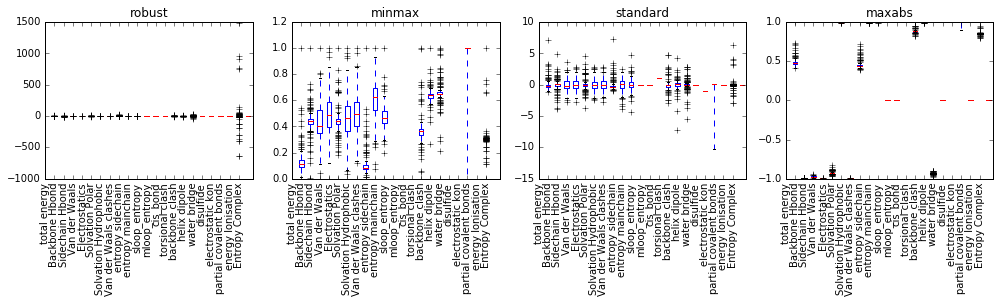

In [46]:
# investigate different scaling methods 

scalers = [ 
    ( 'robust', preprocessing.RobustScaler() ), 
    ( 'minmax', preprocessing.MinMaxScaler() ), 
    ( 'standard', preprocessing.StandardScaler() ), 
    ( 'maxabs', preprocessing.MaxAbsScaler() ), 
]

plt.figure( figsize=(14, 4.3) )
for i, ( scaler_name, scaler ) in enumerate( scalers ):
    plt.subplot( 1, len( scalers ), i + 1 )
    plt.title( scaler_name ) 
    plt.boxplot( scaler.fit_transform( df.ix[:,:-1] ) )
    plt.xticks( range( len( df.columns[:-1] ) ), df.columns[:-1], rotation=90 ) 
plt.tight_layout()    

In [47]:
# scale features and separate into predictors

scl = preprocessing.StandardScaler()
X = scl.fit_transform( df.ix[:,:-1] )
y = df.ix[:,-1].ravel()

print X.shape
print y.shape

(127, 22)
(127,)


In [48]:
# # %matplotlib inline 
# # import matplotlib.pyplot as plt 

# plt.figure( figsize=( 14, 14 ) ) 

# for i, feature in enumerate( df.columns ):
#     plt.subplot( 4, 4, i + 1 ) 
#     plt.scatter( df.expression, df[ feature ], c='k', alpha=0.1 ) #, c=df.expression, cmap='Blues', vmin=-0.5 ) 
#     plt.title( feature ) 
#     plt.xticks( [ 0, 1 ], [ 0, 1 ] ) 

# plt.show()

**FoldX feature set**: individual feature versus expression (yes/no)

In [49]:
#scatter_matrix(df, alpha=0.2, figsize=(14, 14) ) #, diagonal='kde')

In [50]:
# sequence-based view of features 
#df.plot(subplots=True, style='.', figsize=(14,14))

In [51]:
df.corr(method='spearman')['expression'].drop( 'expression' ).sort_values()

energy Ionisation        -0.220161
total energy             -0.158352
helix dipole             -0.119802
entropy sidechain        -0.103522
backbone clash           -0.092653
Sidechain Hbond          -0.058173
Solvation Polar          -0.039706
Van der Waals clashes    -0.029307
Solvation Hydrophobic    -0.028598
Van der Waals            -0.010872
electrostatic kon         0.012578
entropy mainchain         0.058615
Electrostatics            0.125035
torsional clash           0.138028
Backbone Hbond            0.242183
sloop_entropy                  NaN
mloop_entropy                  NaN
cis_bond                       NaN
water bridge                   NaN
disulfide                      NaN
partial covalent bonds         NaN
Entropy Complex                NaN
Name: expression, dtype: float64

In [52]:
# unbalanced classes 
my_list = list( y ) 
print my_list.count( 0 ), 'samples of class 0'
print my_list.count( 1 ), 'samples of class 1'

37 samples of class 0
90 samples of class 1


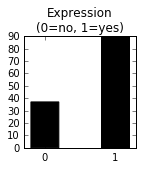

In [53]:
plt.figure( figsize=( 2,2 ) ) 
plt.hist( y, bins=2, color='k', rwidth=0.4 )
plt.xticks( [ .25, .75 ], [ '0', '1' ] ) 
plt.title( 'Expression\n(0=no, 1=yes)' ) 

In [54]:
# Split the dataset in two equal parts to be used to train and test 3 classifiers below 
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.5)

[[13  5]
 [32 14]]
             precision    recall  f1-score   support

          0       0.29      0.72      0.41        18
          1       0.74      0.30      0.43        46

avg / total       0.61      0.42      0.43        64



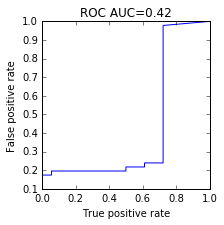

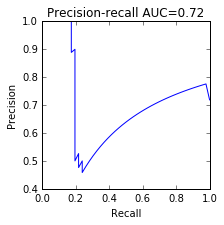

In [55]:
# random forest

from sklearn.naive_bayes import GaussianNB

param_grid = [{}]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

print confusion_matrix( y_true, y_pred )
print classification_report( y_true, y_pred )

y_desc = clf.predict_proba( X_test )
y_prob = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

# Feature importance 
# feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
# w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
# w.set_index( 'feature', inplace=True ) 
# w.sort_values( by='importance', ascending=False )

In [56]:
from sklearn.naive_bayes import GaussianNB

param_grid = [{}]
  
pln = pipeline.Pipeline([
    ( 'nb', GaussianNB() ),
])

# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X, y )
preds = clf.predict( X )
prob = clf.predict_proba( X ) 

print preds

print confusion_matrix( y, preds )
print classification_report( y, preds ) 

[1 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0
 0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0]
[[32  5]
 [67 23]]
             precision    recall  f1-score   support

          0       0.32      0.86      0.47        37
          1       0.82      0.26      0.39        90

avg / total       0.68      0.43      0.41       127



In [57]:
# random forest

param_grid = [
    { 
        'rf__criterion': [ 'entropy', 'gini' ], 
        'rf__n_estimators': [ 10, 50 ], 
        'rf__max_features': [ 1, 2, 'sqrt', None ], 
        'rf__max_depth': [ 2, 3, 6 ], 
        'rf__class_weight': [ 'balanced_subsample' ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'rf', ensemble.RandomForestClassifier() ),
])

precision=0.61, p=0.61


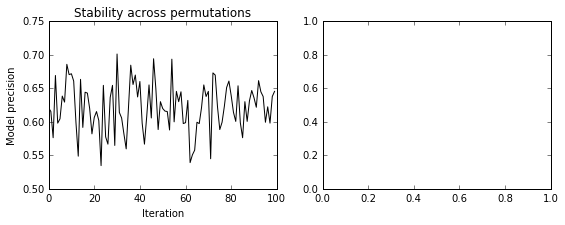

In [58]:
skf = cross_validation.StratifiedKFold( y, 10 ) 
rf = ensemble.RandomForestClassifier( class_weight='balanced_subsample' )

average_score, scores, p_value = cross_validation.permutation_test_score( rf, X, y, cv=skf, scoring='accuracy' ) 

print 'precision={0:2.2f}, p={1:2.2f}'.format( average_score, p_value ) 

plt.figure( figsize=( 9, 3 ) )
plt.subplot( 1, 2, 1 ) 
plt.plot( range( len( scores ) ), scores, color='k' )
plt.xlabel( 'Iteration' ) 
plt.ylabel( 'Model precision' ) 
plt.title( 'Stability across permutations' ) 

plt.subplot( 1, 2, 2 ) 


             precision    recall  f1-score   support

          0       0.25      0.11      0.15        18
          1       0.71      0.87      0.78        46

avg / total       0.58      0.66      0.61        64

[[ 2 16]
 [ 6 40]]


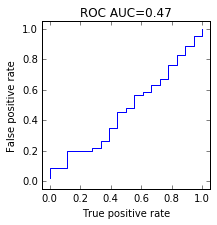

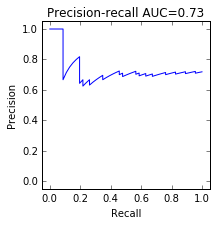

,importance
feature,
Van der Waals,0.113685
Sidechain Hbond,0.094426
entropy sidechain,0.093789
helix dipole,0.090166
total energy,0.077608
Electrostatics,0.077535
torsional clash,0.074423
Solvation Polar,0.073685
entropy mainchain,0.067584


In [59]:
# fit the model 
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

# predict class labels in test set 
y_true, y_pred = y_test, clf.predict(X_test)

# print("Best parameters found on training set")
# print(clf.best_params_)

# print("Grid scores on training set")
# for params, mean_score, scores in clf.grid_scores_:
#     print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

#print("Detailed classification report")

from sklearn.metrics import confusion_matrix

print classification_report( y_true, y_pred )
print confusion_matrix( y_true, y_pred ) 

y_desc = clf.predict_proba( X_test )
y_prob = y_desc[:,1] #[ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

# ROC curve 
tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'ROC AUC={0:.2f}'.format( my_auc ) ) 
plt.xlim( -0.05, 1.05 ) 
plt.ylim( -0.05, 1.05 ) 
plt.show()

# Precision-recall curve 
precision, recall, __ = precision_recall_curve( y_true, y_prob ) 
my_auc = average_precision_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( recall, precision ) 
plt.xlabel( 'Recall' )
plt.ylabel( 'Precision' )
plt.title( 'Precision-recall AUC={0:.2f}'.format( my_auc ) ) 
plt.xlim( -0.05, 1.05 ) 
plt.ylim( -0.05, 1.05 ) 
plt.show()

# Feature importance 
feat_import = clf.best_estimator_.named_steps['rf'].feature_importances_
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

# Tuning hyper-parameters for precision


/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Best parameters set found on development set:
{'svm__C': 3, 'pca__n_components': 10, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}

Grid scores on development set:

0.442 (+/-0.267) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.273 (+/-0.389) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.442 (+/-0.267) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.273 (+/-0.389) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.113 (+/-0.207) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm_

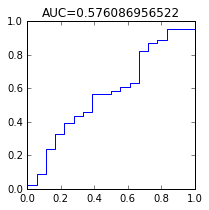

# Tuning hyper-parameters for recall
Best parameters set found on development set:
{'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}

Grid scores on development set:

0.651 (+/-0.296) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'rbf'}
0.429 (+/-0.436) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.001, 'svm__kernel': 'linear'}
0.651 (+/-0.296) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'rbf'}
0.429 (+/-0.436) for {'svm__C': 0.1, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten': True, 'svm__gamma': 0.0001, 'svm__kernel': 'linear'}
0.270 (+/-0.139) for {'svm__C': 0.3, 'pca__n_components': 2, 'svm__class_weight': 'balanced', 'pca__whiten

/usr/local/bin/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


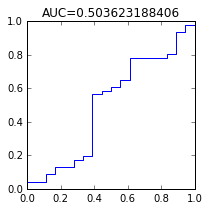

In [60]:
# SVM with PCA 
param_grid = [
    { 
        'svm__kernel': [ 'rbf', 'linear' ], 
        'svm__gamma': [ 1e-3, 1e-4 ],
        'svm__C': [ .1, .3, 3, 30 ],  
        'svm__class_weight': [ 'balanced' ],
        'pca__n_components': [ 2, 5, 10 ], 
        'pca__whiten': [ True ], 
    },
]

scores = ['precision', 'recall']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
        
    pln = pipeline.Pipeline([
        ( 'pca', decomposition.PCA() ), 
        ( 'svm', svm.SVC() ),
    ])

    clf = GridSearchCV(pln, param_grid, cv=10, scoring='%s_weighted' % score)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")

    print(clf.best_params_)
    print 
    print("Grid scores on development set:")
    print 
    for params, mean_score, scores in clf.grid_scores_:
        print("%0.3f (+/-%0.03f) for %r"
              % (mean_score, scores.std() * 2, params))
    print 

    print("Detailed classification report:")
    print 
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print 
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    y_desc = clf.decision_function(X_test) 
    tpr, fpr, __ = roc_curve( y_true, y_desc ) 
    my_auc = roc_auc_score( y_true, y_desc ) 
    plt.figure( figsize=( 3,3 ) ) 
    plt.plot( tpr, fpr ) 
    plt.title( 'AUC={}'.format( my_auc ) ) 
    plt.show()

[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1]
[[13 24]
 [ 4 86]]
             precision    recall  f1-score   support

          0       0.76      0.35      0.48        37
          1       0.78      0.96      0.86        90

avg / total       0.78      0.78      0.75       127



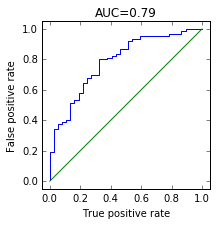

,importance
feature,
Solvation Hydrophobic,0.707194
Backbone Hbond,0.627710
Van der Waals clashes,0.407501
entropy mainchain,0.283038
Electrostatics,0.153094
energy Ionisation,0.012998
disulfide,0.003441
mloop_entropy,0.000000
partial covalent bonds,0.000000


In [61]:
# logistic regression 

# Set the parameters by cross-validation
param_grid = [
    { 
        'logit__class_weight': [ 'balanced', None ], 
    },
]
  
pln = pipeline.Pipeline([
    ( 'logit', LogisticRegressionCV() ),
])

clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X, y )
preds = clf.predict( X )
prob = clf.predict_proba( X )[:,1]
print preds

print confusion_matrix( y, preds )
print classification_report( y, preds ) 

tpr, fpr, __ = roc_curve( y, prob ) 
my_auc = roc_auc_score( y, prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.plot( [0,1], [0,1] ) 
plt.title( 'AUC={0:.2f}'.format( my_auc ) )
plt.xlim( -0.05, 1.05 )
plt.ylim( -0.05, 1.05 )
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )

Best parameters found on training set
{'logit__class_weight': None}
Grid scores on training set
0.508 (±0.414) for {'logit__class_weight': 'balanced'}
0.667 (±0.180) for {'logit__class_weight': None}
Detailed classification report
             precision    recall  f1-score   support

          0       0.00      0.00      0.00        18
          1       0.72      1.00      0.84        46

avg / total       0.52      0.72      0.60        64



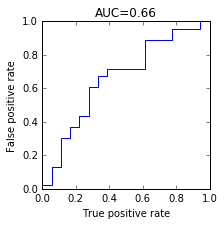

,importance
feature,
torsional clash,5.211534e-04
Backbone Hbond,5.145435e-04
Electrostatics,2.967312e-04
entropy mainchain,2.522888e-04
Van der Waals clashes,2.446917e-04
total energy,1.822085e-04
disulfide,7.513386e-07
sloop_entropy,0.000000e+00
partial covalent bonds,0.000000e+00


In [62]:
clf = GridSearchCV( pln, param_grid, cv=10 )
clf.fit( X_train, y_train )

print("Best parameters found on training set")
print(clf.best_params_)

print("Grid scores on training set")
for params, mean_score, scores in clf.grid_scores_:
    print("%0.3f (±%0.03f) for %r" % (mean_score, scores.std() * 2, params))

print("Detailed classification report")
y_true, y_pred = y_test, clf.predict(X_test)
print(classification_report(y_true, y_pred))

y_desc = clf.predict_proba( X_test )
# gives a pair p(0), p(1) where p is probability and [0,1] are class labels 
# sum to 1 
y_prob = y_desc[:,1] # = [ i[j] for i, j in zip( y_desc, y_true ) ] # the probability for the given class label

tpr, fpr, __ = roc_curve( y_true, y_prob ) 
my_auc = roc_auc_score( y_true, y_prob ) 
plt.figure( figsize=( 3,3 ) ) 
plt.plot( tpr, fpr ) 
plt.xlabel( 'True positive rate' )
plt.ylabel( 'False positive rate' )
plt.title( 'AUC={0:.2f}'.format( my_auc ) ) 
plt.show()

feat_import = clf.best_estimator_.named_steps['logit'].coef_[0]
w = pandas.DataFrame( zip( df.columns[:-1], feat_import ), columns=['feature','importance'] )
w.set_index( 'feature', inplace=True ) 
w.sort_values( by='importance', ascending=False )